In [1]:
#handling files
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
#from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
#from tensorflow.keras.applications.xception import Xception,preprocess_input
#from tensorflow.keras.applications.resnet_rs import ResNetRS101,preprocess_input
#from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
#from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add# This Python 3 environment comes with many helpful analytics libraries installed

In [2]:
pip install rouge

Note: you may need to restart the kernel to use updated packages.


In [3]:
from rouge import Rouge


In [4]:
rouge=Rouge()

In [5]:
BASE_DIR='/kaggle/input/flickr8k'
WORKING_DIR='/kaggle/working'

In [6]:
mod='attention-ResNet50'

In [7]:
#load vgg16 model
model=ResNet50()
# restructure the model
model=Model(inputs=model.inputs,outputs=model.layers[-2].output)
print(model.summary())

102967424/102967424 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

## feature extraction

In [8]:
#extract features from image
features={}
directory=os.path.join(BASE_DIR,'Images')
for img_name in tqdm(os.listdir(directory)):
    #load the image from file
    img_path=directory+'/'+img_name
    image=load_img(img_path,target_size=(224,224))
    #convert image pixels to numpy array
    image=img_to_array(image)
    image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    #preporocess image for vgg
    image=preprocess_input(image)
    #extract features
    feature=model.predict(image,verbose=0)
    #get image id
    image_id=img_name.split('.')[0]
    #store_features
    features[image_id]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [9]:
# store features in pickle
pickle.dump(features,open(os.path.join(WORKING_DIR,'features.pkl'),'wb'))

In [10]:
# load features from pickle
with open(os.path.join(WORKING_DIR,'features.pkl'),'rb') as f:
    features=pickle.load(f)

In [11]:
with open(os.path.join(BASE_DIR,'captions.txt'),'r') as f:
    next(f)
    captions_doc=f.read()

In [12]:
# create mapping for image to captions
mapping={}
# process lines
for line in tqdm(captions_doc.split('\n')):
    #split line by comma
    tokens=line.split(',')
    if len(line)<2:
        continue
    image_id,caption=tokens[0],tokens[1:]
    #remove extension from image_id
    image_id=image_id.split('.')[0]
    #convert caption list to string
    caption=' '.join(caption)
    #create list if needed
    if image_id not in mapping:
        mapping[image_id]=[]
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [13]:
len(mapping)

8091

## text preprocessing

In [14]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            #take one caption at a time
            caption=captions[i]
            #preprocessing steps 
            #convert to lowert case
            caption=caption.lower()
            # delete digitd and special characters
            caption=caption.replace('[^A-Za-z]','')
            # delete additional spaces
            caption=caption.replace('\s+',' ')
            # add start and end tags to the captions
            caption='startseq ' +' '.join([word for word in caption.split() if len(word)>1])+' endseq'
            captions[i]=caption
            

In [15]:
# before preproces of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [16]:
# preprocess the text
clean(mapping)

In [17]:
# after preprocess
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [18]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [19]:
len(all_captions)

40455

In [20]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [21]:
#tokenize the text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [22]:
vocab_size

8485

In [23]:
#get maximum length of the caption
max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

In [24]:
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.90)
#size=int(len(image_ids)*0.99)
train=image_ids[:split]
test=image_ids[split:]
print(len(test))
print(len(train))

810
7281


## data generator

In [25]:
#create data generator to get data in batches (to avoid session crash)
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    #loop over images
    X1,X2,y=list(),list(),list()
    n=0
    while 1:
        for key in data_keys:
            n += 1
            captions=mapping[key]
            #process each caption
            for caption in captions:
                seq=tokenizer.texts_to_sequences([caption])[0]
                #split sequence into X y pairs
                for i in range(1,len(seq)):
                    #split into input and output pairs
                    in_seq,out_seq=seq[:i],seq[i]
                    in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
                    #encode out sequence
                    out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]
                        
                    #store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1,X2,y=np.array(X1),np.array(X2),np.array(y)
                yield [X1,X2],y
                X1,X2,y=list(),list(),list()
                n=0
            
                    

## lstm model

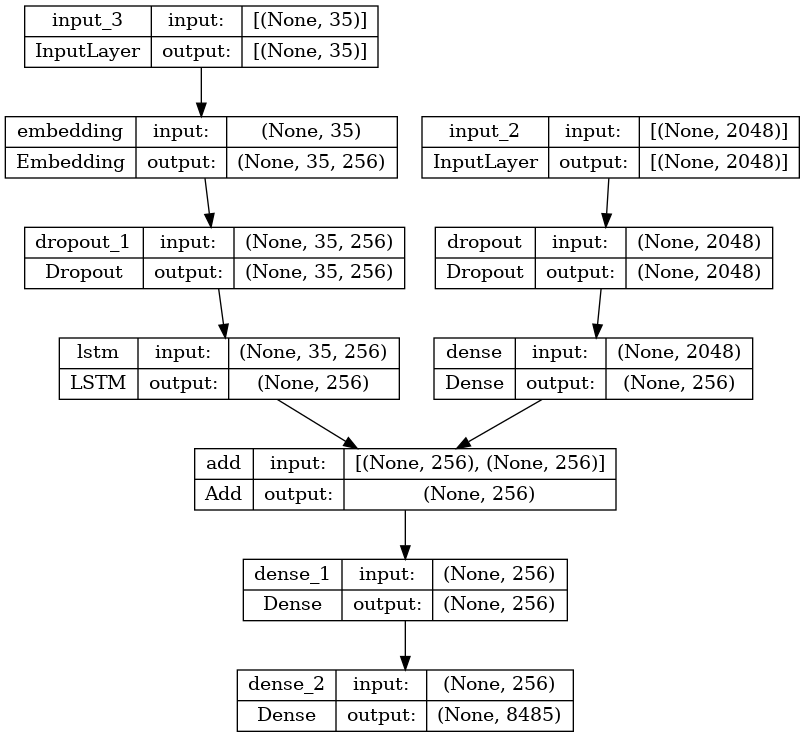

In [26]:
#encoder model
#image feature layers
inputs1=Input(shape=(2048,))
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)
#sequence feature layer
inputs2=Input(shape=(max_length,))
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256)(se2)
#decoder model
decoder1=add([fe2,se3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])


#plot the model
plot_model(model,show_shapes=True)


## attention model

(None, 256)
(None, 35, 256)
(None, 35)
(None, 256)
(None, 35, 256)


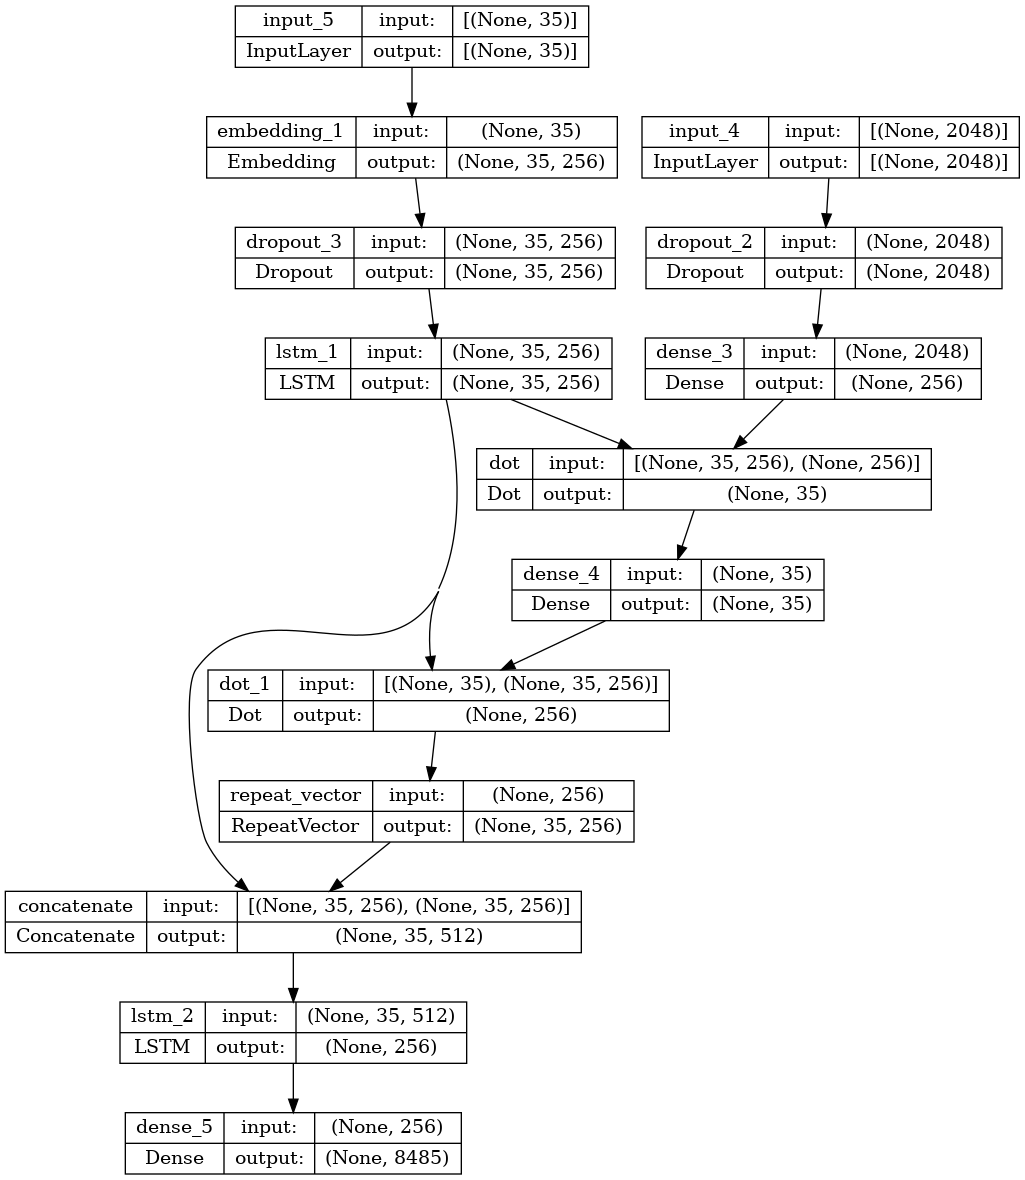

In [27]:

# Import necessary libraries
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate, Dot, RepeatVector, Lambda
from keras.models import Model
from keras.utils import plot_model
from keras import backend as K

# Define the encoder model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

print(fe2.shape)

# Define the sequence feature model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, return_sequences=True)(se2)

print(se3.shape)

# Define the attention mechanism
attention = Dot(axes=[2, 1])([se3, fe2])
attention = Dense(max_length, activation='softmax')(attention)

print(attention.shape)
context = Dot(axes=[1, 1])([attention, se3])
print(context.shape)

# Repeat the context vector 33 times
context = RepeatVector(35)(context)
print(context.shape)

# Concatenate the context vector with the LSTM output
decoder1 = Concatenate(axis=2)([context, se3])
decoder2 = LSTM(256, return_sequences=False)(decoder1)

# Define the output layer
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Define the full model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#plot the model
plot_model(model,show_shapes=True)

In [28]:
#train the model
epochs=5
batch_size=64
steps=len(train)//batch_size


# for i in range(epochs):
#     #create data genereator
#     generator=data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
#     #fit for one epoch
#     #model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
#     model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1 ) 
print(mod)
generator=data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
history= model.fit(generator,epochs=epochs,steps_per_epoch=steps,verbose=1 )

attention-ResNet50
Epoch 1/5
113/113 [==============================] - 85s 673ms/step - loss: 6.3284 - accuracy: 0.0965
Epoch 2/5
113/113 [==============================] - 71s 629ms/step - loss: 5.6751 - accuracy: 0.1204
Epoch 3/5
113/113 [==============================] - 67s 597ms/step - loss: 5.5388 - accuracy: 0.1327
Epoch 4/5
113/113 [==============================] - 67s 596ms/step - loss: 5.3499 - accuracy: 0.1470
Epoch 5/5
113/113 [==============================] - 67s 590ms/step - loss: 5.1714 - accuracy: 0.1704


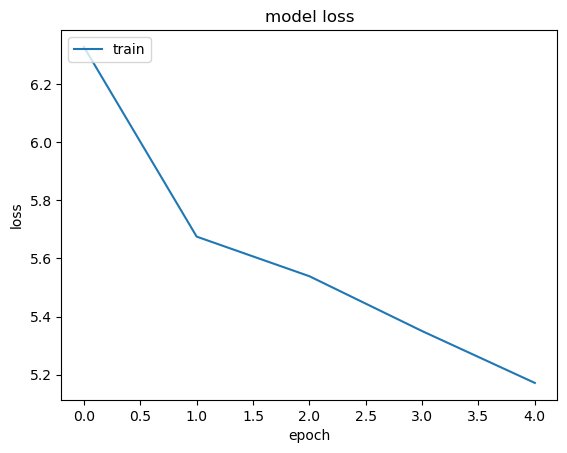

In [29]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

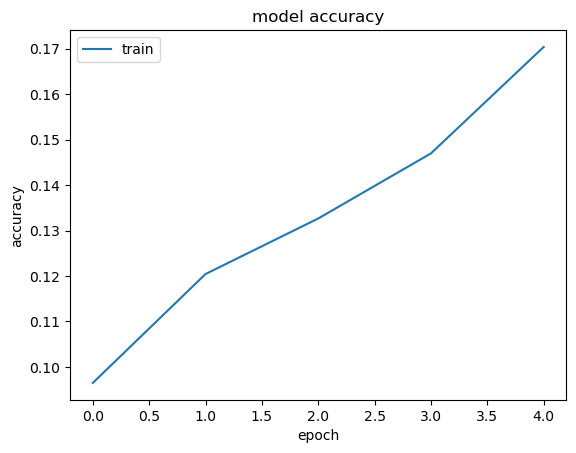

In [30]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [31]:
#save the model
model.save(WORKING_DIR+'best_model.h5')

In [32]:
def idx_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None
        

## predicting caption

In [33]:
# generate caption for the image
def predict_caption(model,image,tokenizer,max_length):
    #add start tag for generation purpose
    in_text='startseq'
    #iterate over the max length of the sequence
    for i in range(max_length):
        #encode input sequence
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        #pad the sequence
        sequence=pad_sequences([sequence],max_length)
        #predict next word
        yhat=model.predict([image,sequence],verbose=0)
        #get index with high probability
        yhat=np.argmax(yhat)
        # convert index to word
        word=idx_to_word(yhat,tokenizer)
        #stop if word is not found
        if word is None:
            break
        #append word as input for generating next word
        in_text+=' '+word
        #stop if we reach end tag
        if word=='endseq':
            break
    return in_text

In [34]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.gleu_score import corpus_gleu
#from nltk.translate.meteor_score import meteor_score
from nltk.translate.ribes_score import sentence_ribes
#validate with test data
actual,predicted=list(),list()
act,pre=[],[]
#actual_meteor,predicted_meteor=list(),list()
for key in tqdm(test):
    cap=""
    #get actual caption
    captions=mapping[key]
    for i in captions :
        cap+=i
    cap=cap.replace('startseq','')
    cap=cap.replace('endseq','')
    # predict the caption for image
    y_pred=predict_caption(model,features[key],tokenizer,max_length)
    #split the words
    c=y_pred
    c=c.replace('startseq','')
    c=c.replace('endseq','')
    pre.append(c)
    #print(cap)
    #print(y_pred)
    y_pred=y_pred.split()
    actual_captions=[caption.split() for caption in captions]
    #append words to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    act.append(cap)
#calculate the BLEU score
print(mod)
print('GLEU: %f '% corpus_gleu(actual,predicted))
print('BLEU-1: %f '% corpus_bleu(actual,predicted,weights=(1,0.0,0,0)))
print('BLEU-2: %f '% corpus_bleu(actual,predicted,weights=(0,1,0,0)))
print('BLEU-3: %f '% corpus_bleu(actual,predicted,weights=(0,0.0,1,0)))
print('BLEU-4: %f '% corpus_bleu(actual,predicted,weights=(0,0,0,1)))
rouge.get_scores(pre,act,avg=True)

  0%|          | 0/810 [00:00<?, ?it/s]

attention-ResNet50
GLEU: 0.028914 
BLEU-1: 0.109705 
BLEU-2: 0.019153 
BLEU-3: 0.001561 
BLEU-4: 0.000037 


{'rouge-1': {'r': 0.09557704030952552,
  'p': 0.6367283950617284,
  'f': 0.16503092439604053},
 'rouge-2': {'r': 0.012485548177477114,
  'p': 0.11820987654320987,
  'f': 0.02247033663399395},
 'rouge-l': {'r': 0.08463132542200293,
  'p': 0.5604938271604938,
  'f': 0.14600089482757309}}

In [35]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id=image_name.split('.')[0]
    image_name=Image.open(os.path.join(BASE_DIR,'Images',image_name))
    captions=mapping[image_id]
    for caption in captions:
        print(caption)
    #predict the caption
    y_pred=predict_caption(model,features[image_id],tokenizer,max_length)
    print('predicted statement')
    print(y_pred)
    plt.imshow(image_name)

attention-ResNet50
startseq brown and white dog is running through the snow endseq
startseq dog is running in the snow endseq
startseq dog running through snow endseq
startseq white and brown dog is running through snow covered field endseq
startseq the white and brown dog is running over the surface of the snow endseq
predicted statement
startseq man is in the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


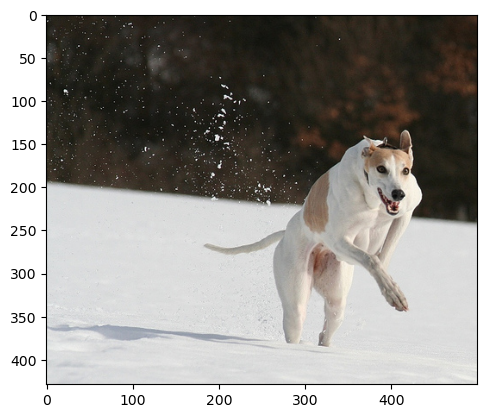

In [36]:
print(mod)
generate_caption('101654506_8eb26cfb60.jpg')

attention-ResNet50
startseq man in blue shorts is laying in the street endseq
startseq man in blue shorts lays down outside in parking lot endseq
startseq man laying down in middle of street during heavy traffic endseq
startseq man lies on mat in parking lot between brown suv and yellow pickup with an open door endseq
startseq shirtless man is laying down in the middle of busy street endseq
predicted statement
startseq man is in the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


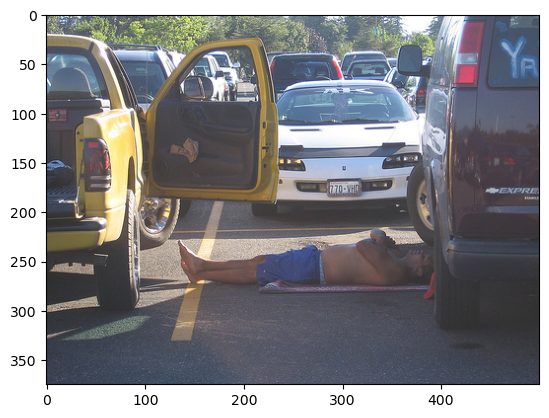

In [37]:
print(mod)
generate_caption('1067675215_7336a694d6.jpg')

attention-ResNet50
startseq boy in blue shorts slides down slide into pool endseq
startseq boy in blue swimming trunks slides down yellow slide into wading pool with inflatable toys floating in the water endseq
startseq boy rides down slide into small backyard pool endseq
startseq boy sliding down slide into pool with colorful tubes endseq
startseq child is falling off slide onto colored balloons floating on pool of water endseq
predicted statement
startseq man is in the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


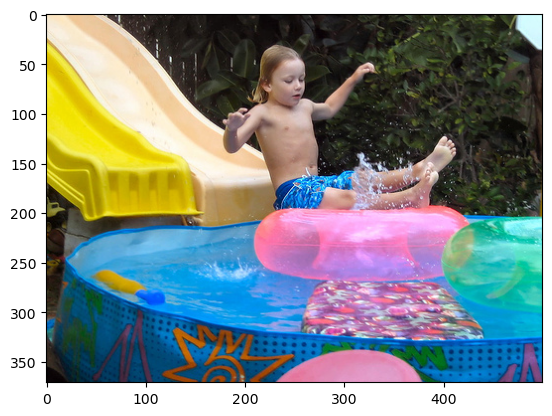

In [38]:
print(mod)
generate_caption('1077546505_a4f6c4daa9.jpg')

attention-ResNet50
startseq woman crouches near three dogs in field endseq
startseq three dogs are playing on grassy hill with blue sky endseq
startseq three dogs are standing in the grass and person is sitting next to them endseq
startseq three dogs on grassy hill endseq
startseq three dogs stand in grassy field while person kneels nearby endseq
predicted statement
startseq man is in the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


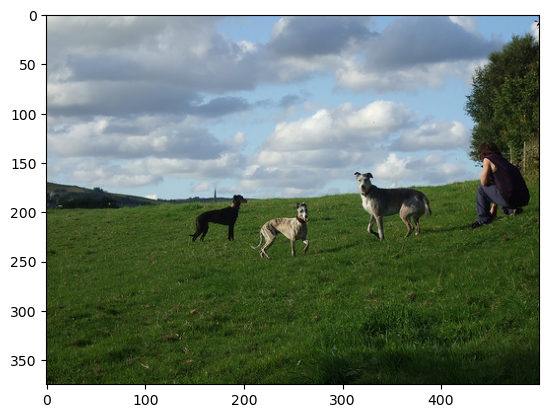

In [39]:
print(mod)
generate_caption('1032122270_ea6f0beedb.jpg')

attention-ResNet50
startseq two different breeds of brown and white dogs play on the beach endseq
startseq two dogs are making turn on soft sand beach endseq
startseq two dogs playing in the sand at the beach endseq
startseq two dogs playing together on beach endseq
startseq two large tan dogs play along sandy beach endseq
predicted statement
startseq man is in the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


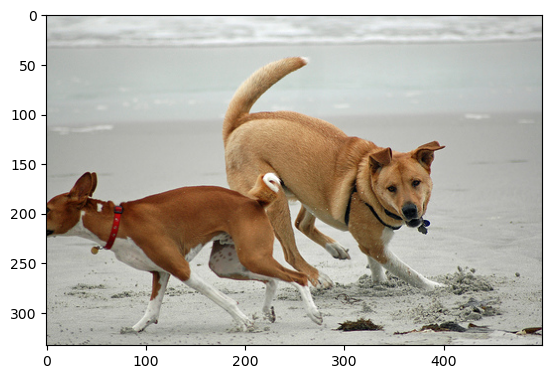

In [40]:
print(mod)
generate_caption('1024138940_f1fefbdce1.jpg')

attention-ResNet50
startseq brown dog is running after black dog on rocky shore endseq
startseq brown dog is running after the black dog endseq
startseq two dogs playing on beach endseq
startseq two dogs run across stones near body of water endseq
startseq two dogs run towards each other on rocky area with water in the background endseq
predicted statement
startseq man is in the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


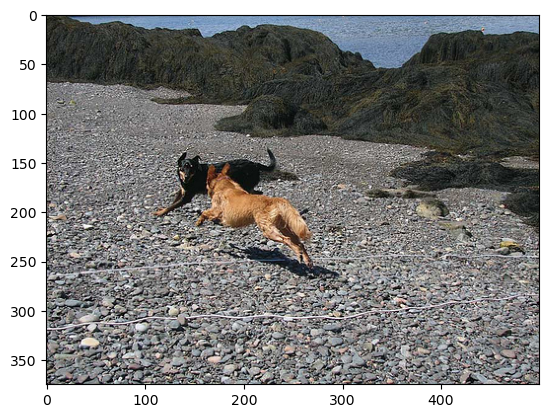

In [41]:
print(mod)
generate_caption('1056873310_49c665eb22.jpg')